<h2> Construction of a Reduced Basis Space for the Helmholz Equation </h2>

We want to create a reduced basis space for the Helmholz equation
\begin{equation}
    \Delta u - \omega^2u = f
\end{equation}

defined on a two dimensional space $\Omega$. It has the following variational form in a finite element space $V_h$. Find an $u_h$ so that

\begin{equation}
    \int_{\Omega} \nabla u_h \nabla v_h \text{dx} - \omega^2 \int_{\Omega} u_hv_h \text{dx} - i\omega \int_{\partial \Omega} u_hv_h \text{ds} = \int_{\Omega} fv_h \text{dx}
\end{equation}

holds for all $v_h \in V_h$. We can write this as an equation of bilinearforms 

\begin{equation}
    k(u_h, v_h) - \omega^2 m(u_h, v_h) - i\omega r(u_h,v_h)= \int_{\Omega} fv_h \text{dx}  \tag{1}
\end{equation}

where $r$ only exists if we want Robin boundary conditions, otherwise $r(u,v) \equiv 0$. To get Dirichlet boundaries, we choose our test functions $v$ from the Sobolev space $H_0^1(\Omega)$ and Neumann boundaries are enforced for $v \in H^1(\Omega)$. 


<h3> The reduced basis method </h3>

In a nutshell the idea of creating a reduced basis space is to choose a so called snapshot of $N$ parameters $ \{ \omega_1, .., \omega_N \} $ for which we solve the system $(1)$. By doing so we get linearly independent snapshot solutions $\{u_h^1, .., u_h^N\}$. The space 
\begin{equation}
V_N := \overline{\text{span}\{u_h^1, .., u_h^N\}}
\end{equation}
is a linear subspace of $V_h$. To approximate a solution for an arbitrary $\omega$ we now have to solve the system $(1)$ only for $v_N \in V_N$, which is computationally way less expensive than solving the original system. 

<h3> Generate a Reduced Basis Space </h3>

We first need to import some libraries and then we write a little python class. 

The input parameter for the class is the finite element space and a coefficient function $f$. 

In [20]:
from ngsolve import *
import numpy as np
import scipy
import scipy.sparse as sparse
import math
from ngsolve.webgui import Draw

class ReducedBasis:

    def __init__(self, fes, f):
        self.setSpace(fes, f)
        self.logging = True

The `setSpace` and `reset` functions just (re-)set some parameters we will need later. 

In [32]:
class ReducedBasis(ReducedBasis):

    def setSpace(self, fes, func):

        self.fes = fes
        
        # assume robin bnd if fes is complex
        if fes.is_complex:
            self.robin = True
        else:
            self.robin = False

        # set (bi-)linear forms and matrices
        self.omega = Parameter(0)
        
        ##########################################
        ## TODO: combine (bi-)linear forms instead of allocating new one
        u,v =self.fes.TnT()
        self.a = BilinearForm(self.fes)
        self.a += (grad(u)*grad(v) - self.omega*self.omega *u*v) * dx
        if self.robin:
            self.a += -1j*self.omega*u*v*ds
        self.a.Assemble()
        ##########################################

        self.f = LinearForm(self.fes)
        self.f += func * v * dx
        self.f.Assemble()

        self.k_blf = BilinearForm(self.fes)
        self.k_blf += grad(u)*grad(v)*dx
        self.k_blf.Assemble()
        rows,cols,vals = self.k_blf.mat.COO()
        self.K_orig = sparse.csr_matrix((vals,(rows,cols)))

        self.m_blf = BilinearForm(self.fes)
        self.m_blf += u*v * dx
        self.m_blf.Assemble()
        rows,cols,vals = self.m_blf.mat.COO()
        self.M_orig = sparse.csr_matrix((vals,(rows,cols)))

        if self.robin:
            self.r_blf = BilinearForm(self.fes)
            self.r_blf += -1j*u*v*ds
            self.r_blf.Assemble()
            rows,cols,vals = self.r_blf.mat.COO()
            self.R_orig = sparse.csr_matrix((vals,(rows,cols)))
    

        # initialize grid functions
        self.gfu = GridFunction(self.fes)
        self.drawu = GridFunction(self.fes)

        self.reset()

    
    def reset(self):
        # reset dynamically updated parameters
        self.K_red = None
        self.M_red = None
        self.P_red = None
        self.R_red = None
        self.sol = []
        self.norm = [] 
        self.residual = []
        self.__V = None  # snapshot solutions
        self.__snapshots_updated = True
        self.__snapshots = [] # snapshot parameters
        self.__indices = []


Next we can create a function that takes a list of omegas and sets them as snapshots. To have the possibility to dynamically expand our reduced basis later on, we will expand the list of snapshot parameters instead of resetting them if `reset==False`. We will also add a get function. 

In [22]:
class ReducedBasis(ReducedBasis):

    def setSnapshots(self, new_snapshots, reset = True, compute_RB = True):
        
        # TODO: check that snapshots do not already exist
        if len(self.__snapshots) > 0 and not reset:
            if self.logging: print("append snapshots with {}".format(new_snapshots))
            self.__snapshots = np.append(self.__snapshots, np.array(new_snapshots))
        else:
            if self.logging: print("set snapshots and reset basis")
            self.__snapshots = np.array(new_snapshots)
            self.__V = None

        self.__snapshots_updated = True

        # store smallest and biggest snapshot parameter
        self.omega_min = min(self.__snapshots)
        self.omega_max = max(self.__snapshots)

        # store indices of snapshots in ascending order
        tmp = self.__snapshots
        zip_to_sort = list(zip(tmp, range(len(tmp))))
        sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=False)
        self.__indices = [tup[1] for tup in sorted_zip]

        if compute_RB:
            self.__computeRB()

    def getSnapshots(self):
        return self.__snapshots[self.__indices]

Let $n$ be the dimension of the original space $V_h$. The snapshot solutions $\{u_h^1, .., u_h^N\}$ could be used directly as basis functions for $V_N$. However we prefer the matrix $V \in \mathbb{R}^{n\times N} $ that contains the coefficients of the reduced basis functions $\{\zeta^1, .., \zeta^N\}$  to be as pretty as possible. Therefore we make sure that the coefficient vectors of the $\zeta_i$ form an ortonormal system respective the Euklidean norm. This we achieve by performing a QR-decomposition and only using the Q part. 


We now solve the equation $(1)$ in the original space for the new snapshots. If the matrix $V$ already contains some basis functions, we extend the basis. 

In [23]:
class ReducedBasis(ReducedBasis):
    
    def __computeRB(self):


        if self.logging: print("compute Reduced Basis")

        if len(self.__snapshots) == 0:
            if self.logging: print(""" no snapshots given, please call 'instance.setSnapshots' first""")
            return
        
        dim_orig = len(self.gfu.vec)
        dim_red = len(self.__snapshots)

        if self.robin:
            V_tmp = np.zeros((dim_orig, dim_red), dtype=complex )
        else:
            V_tmp = np.zeros((dim_orig, dim_red))

        # extend basis if it already exists
        try: 
            existing_basis_len = self.__V.shape[1]
            V_tmp[:,0:existing_basis_len] = self.__V
            if self.logging: print("extend reduced basis")

        except:
            existing_basis_len = 0


        with TaskManager(pajetrace=100*1000*1000):

            for n in range(0+existing_basis_len, dim_red):
                _omega = self.__snapshots[n]
                # compute FEM solution for parameter _omega
                self.omega.Set(_omega)
                self.a.Assemble()

                ## TODO: update inverse instead of recalculating
                self.gfu.vec.data = self.a.mat.Inverse(self.fes.FreeDofs(), inverse="sparsecholesky") * self.f.vec

                V_tmp[:,n] = self.gfu.vec.FV().NumPy()        


            # do QR-decomposition 
            q, r = np.linalg.qr(V_tmp)
            self.__V = V_tmp.dot(np.linalg.inv(r))

            # rearange V and snapshots due to the order of the snapshots
            self.__V = self.__V[:, self.__indices]
            self.__snapshots = self.__snapshots[self.__indices]
            self.__indices = range(dim_red)

            # set system in reduced basis space
            self.K_red = np.transpose(self.__V).dot(self.K_orig.dot(self.__V))
            self.M_red = np.transpose(self.__V).dot(self.M_orig.dot(self.__V))
            self.P_red = np.transpose(self.__V).dot(self.f.vec.data)

            if self.robin:
                self.R_red = np.transpose(self.__V).dot(self.R_orig.dot(self.__V))

            self.__snapshots_updated = False
            if self.logging: print("finished computing Reduced Basis")


To look at the solutions of the reduced system, we want to implement a draw function, that takes a parameter $\omega$, computes the reduced solution and displays it in the ngsolve webgui.

In [24]:
class ReducedBasis(ReducedBasis):
    
    def draw(self, omega, redraw=False):
        
        if self.__snapshots_updated:
            self.__computeRB()
        
        # compute reduced basis
        
        ## TODO: make LU decomposition once  (for M and K) and use np.linalg.solve_triangular
        ## (vorwaerts- und rueckwaertssubstitution)
        if self.robin:
            Ainv = np.linalg.inv(self.K_red-omega*omega*self.M_red+omega*self.R_red)
        else:
            Ainv = np.linalg.inv(self.K_red-omega*omega*self.M_red)
        red_sol_vec = np.matmul(Ainv, self.P_red)
        
        self.drawu.vec.FV().NumPy()[:] = self.__V.dot(red_sol_vec)[:]
        if self.logging: print("omega: {}, norm of solution: {}".format(omega, Integrate ( (self.drawu)*(self.drawu), self.fes.mesh)))
        # draw solution
        if not redraw:
            self.scene = Draw(self.drawu)
        else:
            self.scene.Redraw()


To test the implementation so far, we define an H1-FEM space on the unit square with robin boundary values. To compute the first set of snapshot solutions we choose the parameters $\omega \in \{0, .., 50\}$. Subsequently we create a slider to visualize the reduced solutions for a set of omegas. 

In [34]:
from netgen.geom2d import unit_square
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
fes = H1(mesh, order=5, complex=True)

x_0 = 0.5
y_0 = 0.5
func = 1e3*exp(-(100**2)*((x-0.5)*(x-x_0) + (y-0.5)*(y-y_0)))

space = ReducedBasis(fes, func)
snapshots = np.arange(1,50, 5)
space.setSnapshots(snapshots)

slider_func = lambda x: space.draw(x, redraw=True)
space.draw(space.omega_min)

set snapshots and reset basis
compute Reduced Basis
finished computing Reduced Basis
omega: 1, norm of solution: (-0.006495063354780325+0.0011167140798632618j)


<IPython.core.display.Javascript object>

NGSWebGuiWidget(render_data={'ngsolve_version': '6.2.2004-130-gfb7cad4a7', 'mesh_dim': 2, 'order2d': 2, 'order…

In [35]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(slider_func, x=widgets.FloatSlider(min=space.omega_min, max=space.omega_max, step=0.2, value=space.omega_min))

interactive(children=(FloatSlider(value=1.0, description='x', max=46.0, min=1.0, step=0.2), Output()), _dom_cl…

<function __main__.<lambda>(x)>

We now want to plot the norms and residuals of the solutions for a large set of different omegas. Therefore we extend our class by a function that takes a vector of omegas and stores the corresponding values in the vectors `self.norm` and `self.residual`.

In [27]:
class ReducedBasis(ReducedBasis):
    
    def computeValues(self, param, residual=True, norm=True):

        if self.__snapshots_updated:
            self.__computeRB()
        
        
        if residual and norm: 
            if self.logging: print("compute residual and norm")
        elif residual: 
            if self.logging: print("compute residual")
        elif norm: 
            if self.logging: print("compute norm")
        else: return
        
        self.norm = []
        self.residual = []

        # temporary variables
        ured = GridFunction(self.fes)
        ngs_temp = self.k_blf.mat.CreateColVector()
        ngs_temp2 = self.k_blf.mat.CreateColVector()
        
        with TaskManager(pajetrace=100*1000*1000):

            for _omega in param:

                ## TODO: make LU decomposition once  (for M and K) and use np.linalg.solve_triangular
                ## (vorwaerts- und rueckwaertssubstitution)
                if self.robin:
                    Ainv = np.linalg.inv(self.K_red-_omega*_omega*self.M_red+_omega*self.R_red)
                else:
                    Ainv = np.linalg.inv(self.K_red-_omega*_omega*self.M_red)
                red_sol_vec = np.matmul(Ainv, self.P_red)

                ured.vec.FV().NumPy()[:] = self.__V.dot(red_sol_vec)

                if norm:

                    nof = Integrate(ured*Conj(ured), self.fes.mesh)
                    self.norm += [nof]

                if residual:                                  

                    ngs_temp.data = self.k_blf.mat*ured.vec - _omega*_omega*self.m_blf.mat*ured.vec - self.f.vec
                    if self.robin:
                        ngs_temp.data += _omega*self.r_blf.mat*ured.vec

                    ngs_temp2.data = Projector(self.fes.FreeDofs(), True)*ngs_temp

                    res = Norm(ngs_temp2)

                    self.residual += [res]


Again we define an instance of our now updated class. Afterwards we can plot norm and residuals for a set of random omegas. 

In [28]:
space = ReducedBasis(fes, func)
space.setSnapshots(snapshots)

random_omegas = np.sort(np.append(np.random.uniform(space.omega_min, space.omega_max, 1000), snapshots))
space.computeValues(random_omegas)
residual_random_omegas = space.residual
norm_random_omegas = space.norm

set snapshots and reset basis
compute Reduced Basis
finished computing Reduced Basis
compute residual and norm


<IPython.core.display.Javascript object>


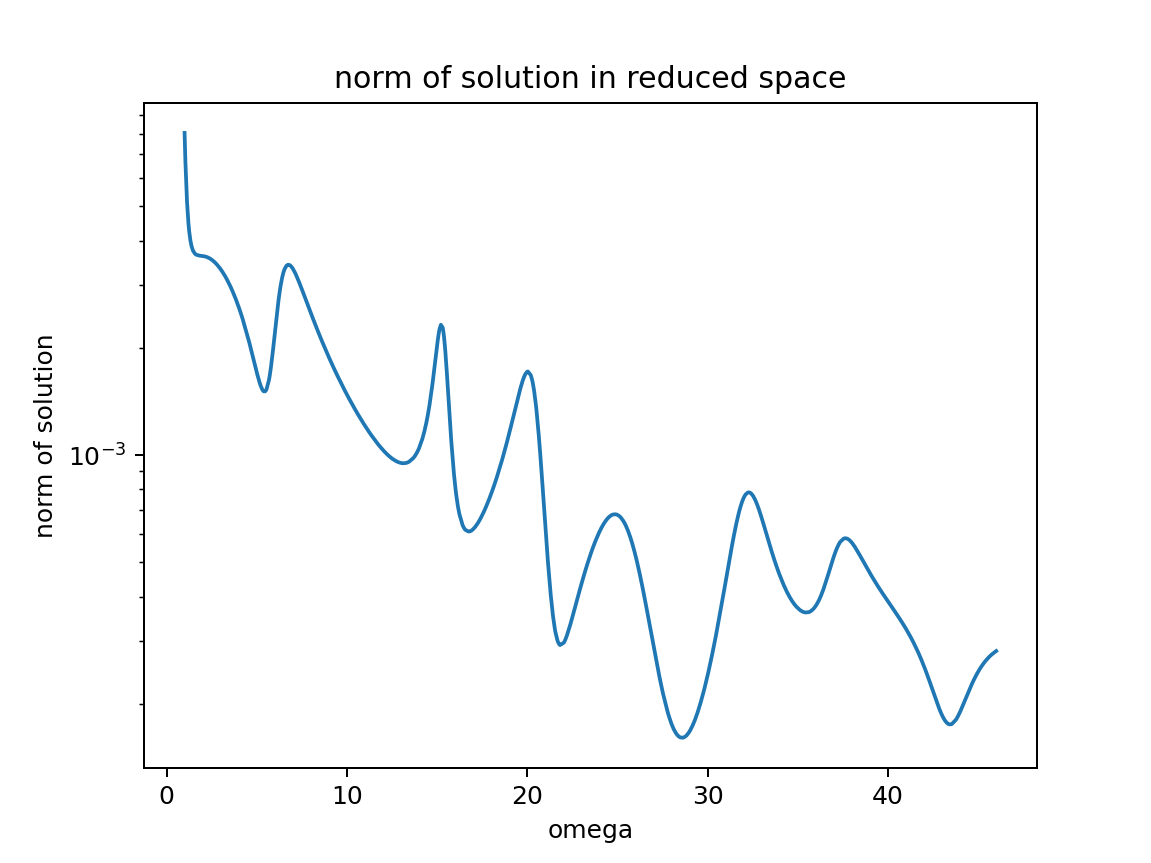

/home/ams/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


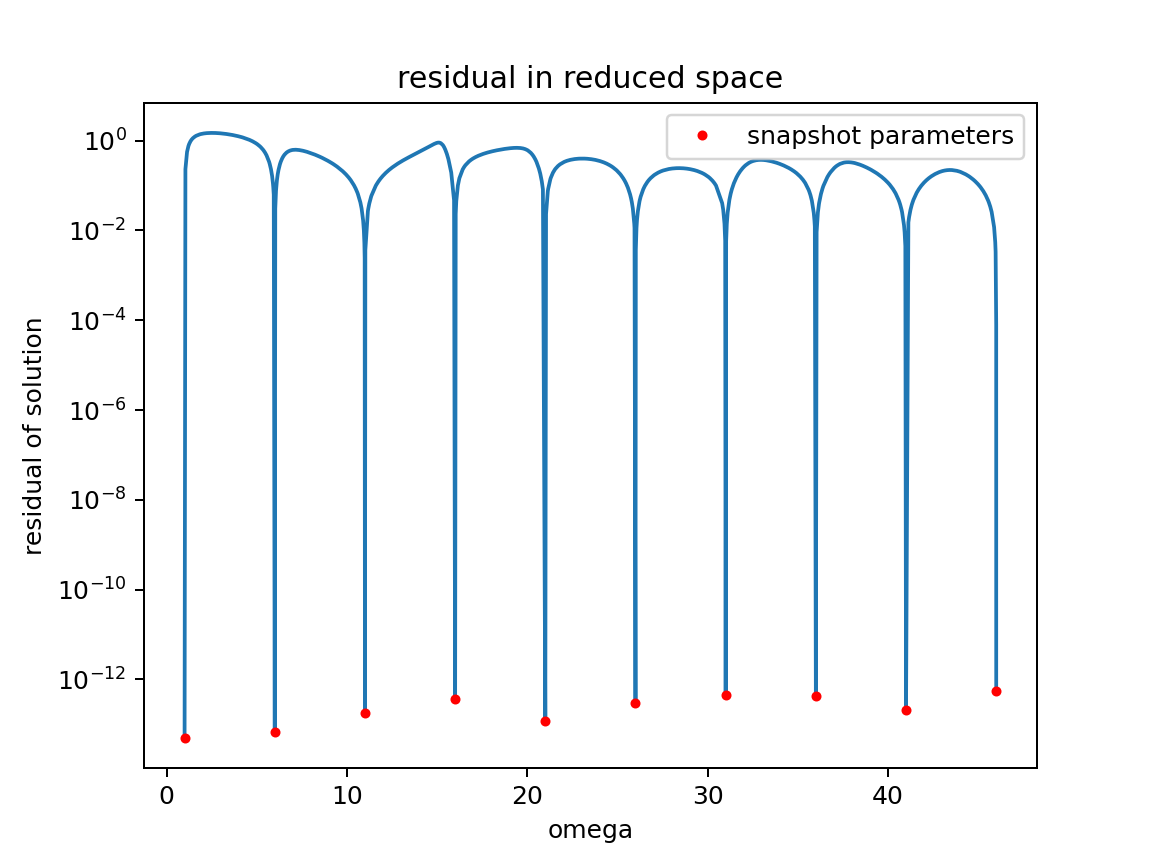

compute residual and norm


[]

In [29]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(random_omegas, norm_random_omegas,  '-', label = "norm")
ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()

fig, ax = plt.subplots()         
ax.plot(random_omegas, residual_random_omegas , '-')
space.computeValues(space.getSnapshots())
ax.plot(space.getSnapshots(), space.residual, 'r.', label = "snapshot parameters")
ax.legend()
ax.set_xlabel("omega")
ax.set_ylabel('residual of solution')
ax.set_title("residual in reduced space")
plt.semilogy()

<h3> A greedy way to choose snapshot parameters </h3>


From the plots we can also observe, that the density of the eigenvalues increases with higher values of $\omega$. Our sample rate however does not change because we choose equidistant snapsots. This causes an offset in the residual too, which is something we don't want.  

One way to tackle this issue is to choose the snapshots dynamically. Therefore we can start with a small set of snapshot parameters and extend this set with the value where the residual is the highest.

To see what is going on, we plot the residual for each new snapshot.

<IPython.core.display.Javascript object>


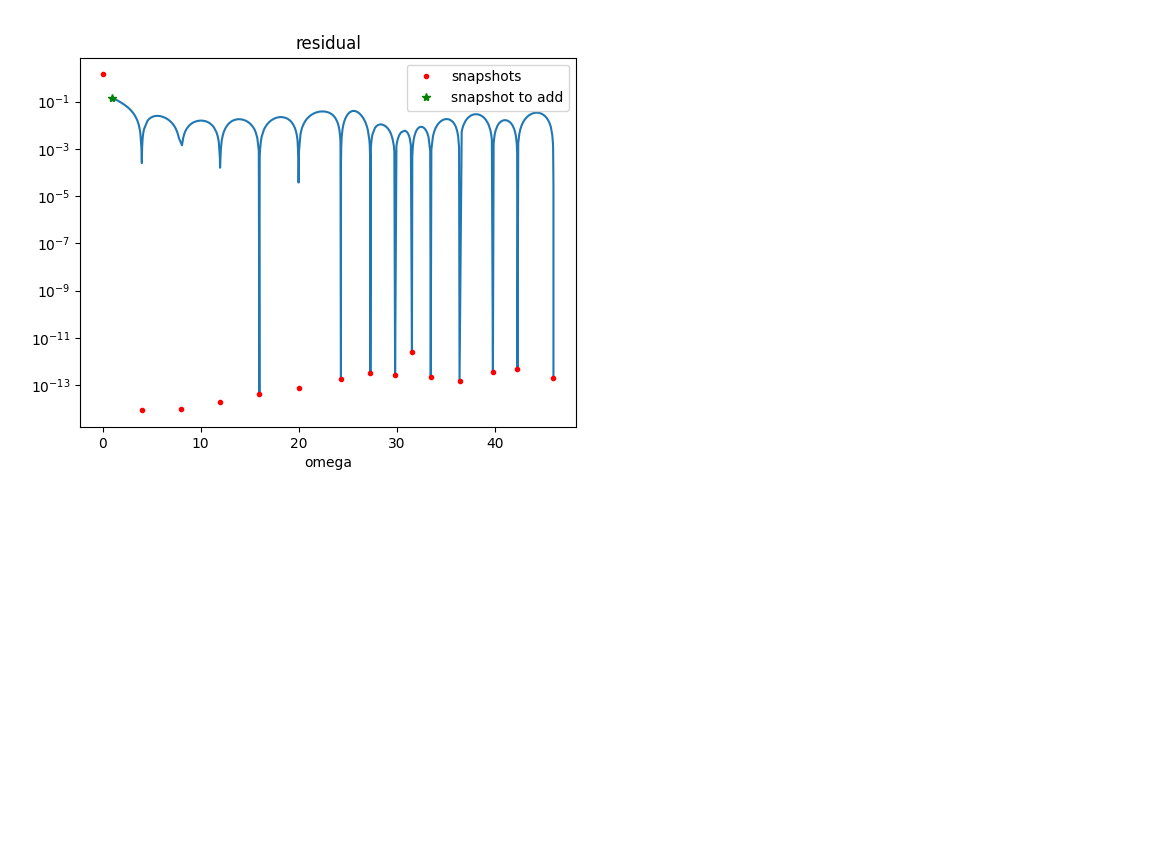

KeyboardInterrupt: 

In [30]:
import time

space.logging = False
space.setSnapshots(range(1,20+4, 4), reset=True, compute_RB = True)

MAX_IT = 20

# initialize plot
fig_r = plt.figure()
ax_r = fig_r.add_subplot(111)
plt.ion()
fig_r.show()
fig_r.canvas.draw()

for i in range(MAX_IT):
    
    space.computeValues(random_omegas, norm=False)
    residual = space.residual
    
    ax_r.clear()    
    ax_r.plot(random_omegas, residual , '-')
    space.computeValues(space.getSnapshots())
    ax_r.plot(space.getSnapshots(), space.residual, 'r.', label = 'snapshots')
    ax_r.set_xlabel('omega')
    ax_r.set_title('residual')
    plt.semilogy()
    
    # sort by residual (descending)
    zip_to_sort = list(zip(residual, range(len(residual))))
    sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=True)
    index = [tup[1] for tup in sorted_zip]
    
    for i in index:
        if not random_omegas[i] in space.getSnapshots(): 
            space.setSnapshots(random_omegas[i], reset=False, compute_RB = False)
            break
    
    ax_r.plot(random_omegas[i], residual[i], 'g*', label = 'snapshot to add')
    ax_r.legend()

    
    fig_r.canvas.draw()
    space.computeValues(None,residual=False,  norm = False)

    
    time.sleep(0.0001)
    



Again we can calculate and plot the solutions in the new reduced space. 

In [ ]:
slider_func = lambda x: space.draw(x, redraw=True)
space.draw(space.omega_min)

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(slider_func, x=widgets.FloatSlider(min=space.omega_min, max=space.omega_max, step=0.05, value=space.omega_min))

If the slider does not work, executing the following cell will iterate through a list of omegas and draw the functions.

In [ ]:
for p in np.arange(space.omega_min, space.omega_max, 0.05):
    slider_func(p)
    time.sleep(0.1)